In [2]:
import pandas as pd
import os
import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
from shapely.geometry import Point
import folium
import rasterio
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires')
fire_data_classified = pd.read_csv('fires_data_classified.csv', index_col=0)

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\geospatial_internship\\datasets')
telangana_shape = gpd.read_file('telangana_shapefile.geojson')

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\src\\data_preprocessing\\tsdm\\')
district_boundaries = gpd.read_file('District_Boundary.shp')

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\src\\data_preprocessing\\tsdm\\')
mandal_boundaries = gpd.read_file('Mandal_Boundary.shp')

In [4]:
#Select only the agricultural fires
fire_data = fire_data_classified[fire_data_classified['agricultural'] == 1]
del fire_data['agricultural']
len(fire_data)

6373

In [5]:
#Create geodataframe from the data
geo_fire_data = gpd.GeoDataFrame(fire_data,geometry = gpd.points_from_xy(fire_data.longitude,fire_data.latitude), crs = {'init': 'epsg:4326'}) 

#Make sure the geometry columns are in the right format
geo_fire_data['geometry'] = geo_fire_data['geometry'].geometry.to_crs(epsg = 4326)
district_boundaries['geometry'] = district_boundaries['geometry'].geometry.to_crs(epsg = 4326)
mandal_boundaries['geometry'] = mandal_boundaries['geometry'].geometry.to_crs(epsg = 4326)

c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [6]:
#Load date into date format
geo_fire_data['acq_date'] =  pd.to_datetime(geo_fire_data['acq_date'])
geo_fire_data['year'] = (geo_fire_data['acq_date']).dt.year
geo_fire_data['month'] = (geo_fire_data['acq_date']).dt.month

In [7]:
fires_per_mandal= gpd.sjoin(geo_fire_data, mandal_boundaries, how="inner", op='intersects')

fires_per_mandal['day'] = 1
fires_per_mandal['year'] = pd.Series(pd.to_numeric(fires_per_mandal['year'], errors='coerce'), dtype='int64')
fires_per_mandal['month'] = pd.Series(pd.to_numeric(fires_per_mandal['month'], errors='coerce'), dtype='int64')
fires_per_mandal['ModifiedDateTime'] = pd.to_datetime(fires_per_mandal[['year', 'month', 'day']].astype('int64').astype('str'), yearfirst=True)

fires_per_mandal_count = fires_per_mandal.sort_values(by=['Mandal_Nam', 'ModifiedDateTime'])

fires_per_mandal_count = fires_per_mandal.groupby(['Dist_Name', 'Mandal_Nam', 'Area', 'ModifiedDateTime'])['frp'].sum().unstack(fill_value=0).stack().reset_index()
fires_per_mandal_count['frp per squared km'] = fires_per_mandal_count[0] / (fires_per_mandal_count['Area'])
#new_geo_mandal = pd.merge(mandal_boundaries, fires_per_mandal_count, on = ['Dist_Name', 'Mandal_Nam'])
del fires_per_mandal_count[0]

<ipython-input-7-6fd086e0389a>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  fires_per_mandal= gpd.sjoin(geo_fire_data, mandal_boundaries, how="inner", op='intersects')


In [8]:
fires_per_mandal_count= fires_per_mandal_count[(fires_per_mandal_count['ModifiedDateTime']>='2016-01-01') & (fires_per_mandal_count['ModifiedDateTime']<'2021-01-01')]

In [35]:
fires_per_mandal_count['Mandal_Nam'].unique()

array(['Adilabad Rural', 'Bazarhathnoor', 'Bheempoor', 'Boath', 'Ichoda',
       'Inderavelly', 'Jainad', 'Narnoor', 'Sirikonda', 'Talamadugu',
       'Tamsi', 'Utnur', 'Allapalli', 'Annapureddipalle', 'Aswapuram',
       'Aswaraopeta', 'Burgampadu', 'Chandrugonda', 'Cherla',
       'Chunchupally', 'Dammapeta', 'Dummugudem', 'Gundala', 'Julurupad',
       'Karakagudem', 'Laxmidevipally', 'Manuguru', 'Mulakalapally',
       'Palvancha', 'Pinapaka', 'Sujathanagar', 'Tekulapalle', 'Yellandu',
       'Beerpur', 'Buggaram', 'Dharmapuri', 'Gollapalli', 'Ibrahimpatnam',
       'Jagityal_Rural', 'Jagtial', 'Kathlapur', 'Kodimial', 'Korutla',
       'Mallapur', 'Mallial', 'Medipalle', 'Metpalli', 'Pegadapalli',
       'Raikal', 'Sarangapur', 'Velgatur', 'Bachannapet', 'Devaruppula',
       'Ghanpur (Stn)', 'Jangoan', 'Kodakandla', 'Lingalaghanpur',
       'Narmetta', 'Palakurthy', 'Ragunathpally', 'Tharigoppula',
       'Zaffergadh', 'Bhupalpally', 'Chityal', 'Ghanapur_Mulug',
       'Kataram',

In [36]:
#Try out on one mandal 
example_man = fires_per_mandal_count[fires_per_mandal_count['Mandal_Nam'] == 'Narmetta']

In [37]:
series = example_man[['ModifiedDateTime', 'frp per squared km']]
series.set_index('ModifiedDateTime', inplace=True)

In [38]:
result = seasonal_decompose(series, model='additive', period = 5)
#print(result.trend)
#print(result.seasonal)
#print(result.resid)
#print(result.observed)

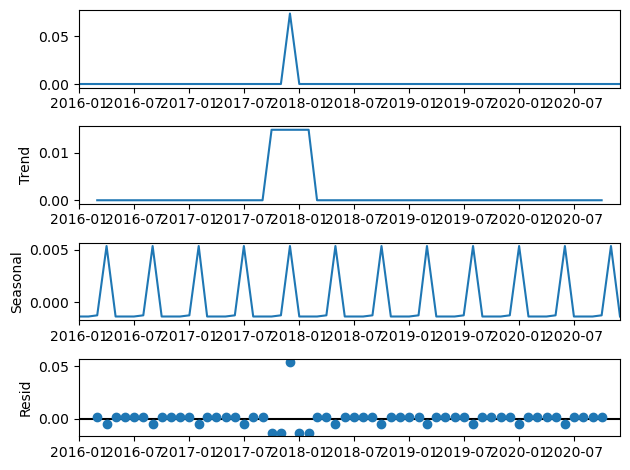

In [39]:
result.plot()
plt.show()

In [27]:
df = pd.DataFrame({})
df.index = result.trend.index

In [28]:
for i in fires_per_mandal_count['Mandal_Nam'].unique():
    example_man = fires_per_mandal_count[fires_per_mandal_count['Mandal_Nam'] == i]
    if len(example_man) == len(df.index):
        series = example_man[['ModifiedDateTime', 'frp per squared km']]
        series.set_index('ModifiedDateTime', inplace=True)
        result = seasonal_decompose(series, model='additive', period = 5)
        df[i] = result.trend.to_list()

<ipython-input-28-92702690ec70>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[i] = result.trend.to_list()


In [29]:
df = df.reset_index()

In [30]:
df['ModifiedDateTime'] = df['ModifiedDateTime'].astype('str')
df = df.set_index('ModifiedDateTime')

In [31]:
trend_df = df.transpose().reset_index()

In [32]:
trend_df['geometry'] = 0
for i in range(0, len(trend_df)):
    trend_df['geometry'].iloc[i] = mandal_boundaries[mandal_boundaries['Mandal_Nam'] == trend_df['index'].iloc[i]]['geometry'].iloc[0]

c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [33]:
trend_df = gpd.GeoDataFrame(trend_df, geometry = trend_df.geometry, crs = {'init': 'epsg:4326'}) 

c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [34]:
trend_df.to_file('C:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires\\trend FRP over time.geojson', driver="GeoJSON")  